# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 
## Homework 3 - Regression Modeling to Forecast Bike Sharing Usage



**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Chris Tanner

<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

<hr style="height:2pt">

![bike_sharing](fig/BSS.png)

<div class="theme">  Main Theme: Multiple Linear Regression, Polynomial Regression, Ridge and Lasso Regression </div>
### Overview 

You are hired by the administrators of the [Capital Bikeshare program](https://www.capitalbikeshare.com) program in Washington D.C., to **help them predict the hourly demand for rental bikes** and **give them suggestions on how to increase their revenue**. Your task is to prepare a short report summarizing your findings and make recommendations.

The predicted hourly demand could be used for planning the number of bikes that need to be available in the system at any given hour of the day. It costs the program money if bike stations are full and bikes cannot be returned, or empty and there are no bikes available. You will use multiple linear regression and polynomial regression and will explore ridge and lasso regression to predict bike usage. The goal is to build a regression model that can predict the total number of bike rentals in a given hour of the day, based on all available information given to you. 

An example of a suggestion to increase revenue might be to offer discounts during certain times of the day either during holidays or non-holidays. Your suggestions will depend on your observations of the seasonality of ridership.

The data for this problem were collected from the Capital Bikeshare program over the course of two years (2011 and 2012).



### Use only the libraries below:

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score

from pandas.plotting import scatter_matrix

### Overview
The initial data set is provided in the file `data/BSS_hour_raw.csv`. You will first add features that will help with the analysis and then separate the data into training and test sets. Each row in this file represents the number of rides by registered users and casual users in a given hour of a specific date. There are 12 attributes in total describing besides the number of users the weather if it is a holiday or not etc: 


- `dteday` (date in the format YYYY-MM-DD, e.g. 2011-01-01)
- `season` (1 = winter, 2 = spring, 3 = summer, 4 = fall)
- `hour` (0 for 12 midnight, 1 for 1:00am, 23 for 11:00pm)
- `weekday` (0 through 6, with 0 denoting Sunday)
- `holiday` (1 = the day is a holiday, 0 = otherwise)
- `weather`
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm
    - 4: Heavy Rain + Thunderstorm + Mist, Snow + Fog 
- `temp` (temperature in Celsius, normalized)
- `atemp` (apparent temperature, or relative outdoor temperature, in Celsius, normalized)
- `hum` (relative humidity, normalized)
- `windspeed` (wind speed, normalized)
- `casual` (number of rides that day made by casual riders, not registered in the system)
- `registered` (number of rides that day made by registered riders)

<div class="exercise"> <b> Question 1 [6pts]: Data Read-In and Processing </b> </div>

In this section, we read in the data and begin one of the most important analytic steps: verifying that the data is what it claims to be.

**1.1** Load the dataset from the csv file `data/BSS_hour_raw.csv` into a pandas dataframe that you name `bikes_df_raw`. Do any of the variables' ranges or averages seem suspect? Do the data types make sense?

**1.2** Notice that the variable in column `dteday` is a pandas `object`, which is **not**  useful when you want to extract the elements of the date such as the year, month, and day. Convert `dteday` into a `datetime` object to prepare it for later analysis.

**Hint:** http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html

**1.3** Create three new columns in the dataframe:
- `year` with 0 for 2011, 1 for 2012, etc.
- `month` with 1 through 12, with 1 denoting January.
- `counts` with the total number of bike rentals for that **hour** (this is the response variable for later).

### Answers

**1.1 Load the dataset from the csv file...**

In [3]:
# your code here
bikes_df_raw = pd.read_csv("data/BSS_hour_raw.csv")
bikes_df_raw.describe()

,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869
std,1.106918,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000
50%,3.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000
75%,3.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000
max,4.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000


In [4]:
bikes_df_raw.head()

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1


*Your answer here*  
 Workingday and holiday should be opposites. Their means should sum to 1.  
 Normalized variables should have a min and max of 0 and 1, respectively.  
 This is not the case for temp and windspeed.  

**1.2 Notice that the variable in column...**

In [5]:
# your code here
# Timestamp, a subclass of datetime.datetime,
# is pandas’ scalar type for timezone-naive or timezone-aware datetime data.
bikes_df_raw["dteday"] = pd.to_datetime(bikes_df_raw["dteday"])
bikes_df_raw.iloc[0]["dteday"].year

2011

**1.3 Create three new columns in the dataframe:...**

In [6]:
# your code here
bikes_df_raw["year"] = bikes_df_raw["dteday"].apply(lambda row: row.year-2011)
bikes_df_raw["month"] = bikes_df_raw["dteday"].apply(lambda row: row.month)
bikes_df_raw["counts"] = bikes_df_raw.apply(lambda row: row["casual"]+row["registered"], axis=1)

In [7]:
bikes_df_raw.head()

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,year,month,counts
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,0,1,16
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,0,1,40
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,0,1,32
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,0,1,13
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,0,1,1


---

<div class='exercise'> <b> Question 2 [20 pts]: Exploratory Data Analysis. </b></div>

In this question we begin hunting for patterns in ridership that shed light on who uses the service and why.

**2.1** Make a new dataframe with the following subset of attributes from the previous dataset and with each entry being just **one** day: 

- `dteday`, the timestamp for that day (fine to set to noon or any other time) 
- `weekday`, the day of the week
- `weather`, the most severe weather that day
- `season`, the season that day falls in
- `temp`, the average temperature
- `atemp`, the average atemp that day
- `windspeed`, the average windspeed that day
- `hum`, the average humidity that day
- `casual`, the **total** number of rentals by casual users
- `registered`, the **total** number of rentals by registered users
- `counts`, the **total** number of rentals of that day

Name this dataframe `bikes_by_day`.

Make a plot showing  the _distribution_ of the number of casual and registered riders on each day of the week.

**Hint:** helpful to use panda's `.groupby()` command

**2.2** Use `bikes_by_day` to visualize how the distribution of **total number of rides** per day (casual and registered riders combined) varies with the **season**. Do you see any **outliers**? Here we use the pyplot's boxplot function definition of an outlier as any value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. If you see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or a significant event (an online search of those date(s) might help). 

**2.3** Convert the categorical attributes ('season', 'month', 'weekday', 'weather') into multiple binary attributes using **one-hot encoding** and call this new dataframe `bikes_df`.

**2.4** Split the updated `bikes_df` dataset into a 50-50 train-test split (call them `bikes_train` and `bikes_test`, respectively). Do this in a 'stratified' fashion, ensuring that all months are equally represented in each set.  Use `random_state=90`, a test set size of .5, and stratify on month.  Remember to specify the data's index column as you read it in.

**2.5** Although we asked you to create your train and test set, for consistency and easy checking, we ask that for the rest of this problem set you use the train and test set provided in the files `data/BSS_train.csv` and `data/BSS_test.csv`. Read these two files into dataframes `BSS_train` and `BSS_test`, respectively. Remove the `dteday` column from both the train and the test dataset (its format cannot be used for analysis). 

**2.6** Use pandas' `scatter_matrix` command to visualize the inter-dependencies among the list of predictors listed below in the training dataset. Note and comment on any strongly related variables. [This may take a few minutes to run. You may wish to comment it out until your final submission, or only plot a randomly-selected 10% of the rows]

`cor_columns = ['hour', 'holiday', 'temp', 'atemp', 
               'workingday', 'hum', 'windspeed', 
               'counts', 'casual', 'registered',
               'fall', 'summer', 'spring', 
               'Snow', 'Storm', 'Cloudy']`

**2.7** Make a plot showing the _average_ number of casual and registered riders during each hour of the day. `.groupby` and `.aggregate` should make this task easy. Comment on the trends you observe. 

**2.8** Use the one-hot-encoded `weather` related variables to show how each weather category affects the relationships in question 2.6.  Remember you should have four plots, one for each weather type (Cloudy, Storm, Snow, and Clear), even though there are only three columns related to weather after one-hot-encoding. What do you observe?

### Answers

**2.1 Make a new dataframe...**

In [8]:
# your code here
bikes_by_day = pd.DataFrame()
dategroup = bikes_df_raw.groupby(["dteday"], as_index=False)

for k in ["dteday", "weekday", "season", "temp", "atemp", "windspeed", "hum"]:
    bikes_by_day[k] = dategroup.mean()[k]

bikes_by_day["weather"] = dategroup.max()["weather"]

for k in ["casual", "registered", "counts"]:
    bikes_by_day[k] = dategroup.sum()[k]
    
bikes_by_day["year"] = bikes_by_day["dteday"].apply(lambda row: row.year-2011)
bikes_by_day["month"] = bikes_by_day["dteday"].apply(lambda row: row.month)
    
bikes_by_day

,dteday,weekday,season,temp,atemp,windspeed,hum,weather,casual,registered,counts,year,month
0,2011-01-01,6.0,1.0,0.344167,0.363625,0.160446,0.805833,3,331,654,985,0,1
1,2011-01-02,0.0,1.0,0.363478,0.353739,0.248539,0.696087,3,131,670,801,0,1
2,2011-01-03,1.0,1.0,0.196364,0.189405,0.248309,0.437273,1,120,1229,1349,0,1
3,2011-01-04,2.0,1.0,0.200000,0.212122,0.160296,0.590435,2,108,1454,1562,0,1
4,2011-01-05,3.0,1.0,0.226957,0.229270,0.186900,0.436957,1,82,1518,1600,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,2012-12-27,4.0,1.0,0.254167,0.226642,0.350133,0.652917,3,247,1867,2114,1,12
727,2012-12-28,5.0,1.0,0.253333,0.255046,0.155471,0.590000,2,644,2451,3095,1,12
728,2012-12-29,6.0,1.0,0.253333,0.242400,0.124383,0.752917,3,159,1182,1341,1,12
729,2012-12-30,0.0,1.0,0.255833,0.231700,0.350754,0.483333,2,364,1432,1796,1,12


In [9]:
# color the registered users orange
def color_violin(violin_result, color_string):
    """Helper to color a violin plot"""
  
    # color the distribution
    for pc in violin_result['bodies']:
        pc.set_color(color_string)

    # color the lines
    for partname in ('cbars','cmins','cmaxes'):
        vp = violin_result[partname]
        vp.set_edgecolor(color_string)


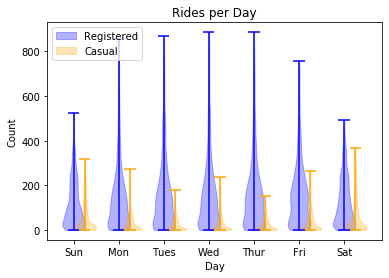

In [10]:
# Data filtering
daycas = []
dayreg = []
for i in range(7):
    daycas.append(np.array(bikes_df_raw[bikes_df_raw["weekday"] == i]["casual"]))
    dayreg.append(np.array(bikes_df_raw[bikes_df_raw["weekday"] == i]["registered"]))
    
# X-ticks
reg_color = 'blue'
casual_color = 'orange'
days_tick_dict = {0: 'Sun', 1: 'Mon', 2: 'Tues', 3: 'Wed',
                 4: 'Thur', 5: 'Fri', 6: 'Sat'}   
plt.xticks(list(days_tick_dict.keys()), list(days_tick_dict.values()))

# Plot
position_array = np.arange(len(dayreg))
reg = plt.violinplot(dataset=dayreg, positions=position_array)
cas = plt.violinplot(dataset=daycas, positions=position_array+.25)

# color the violins
color_violin(reg, reg_color)
color_violin(cas, casual_color)

# Labelling
labels = []
def add_label(violin, label):
    import matplotlib.patches as mpatches
    color = violin["bodies"][0].get_facecolor().flatten()
    labels.append((mpatches.Patch(color=color), label))
add_label(reg, "Registered")
add_label(cas, "Casual") 

# Plot titles etc.
plt.title("Rides per Day")
plt.xlabel("Day")
plt.ylabel("Count")
plt.legend(*zip(*labels), loc=2)

**2.2 Use `bikes_by_day` to visualize how the distribution...**

Text(0, 0.5, 'Count')

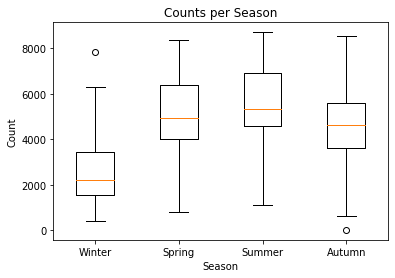

In [11]:
bplot = []
for i in range(1, 5):
    bplot.append(bikes_by_day[bikes_by_day["season"] == i]["counts"])
plt.boxplot(bplot)

plt.xticks([1, 2, 3 , 4], ['Winter', 'Spring', 'Summer', 'Autumn'])
plt.title("Counts per Season")
plt.xlabel("Season")
plt.ylabel("Count")

In [12]:
bikes_by_day.loc[(bikes_by_day.season == 1) & (bikes_by_day.counts > 7000)]
# Saint Patrick's Day

,dteday,weekday,season,temp,atemp,windspeed,hum,weather,casual,registered,counts,year,month
441,2012-03-17,6.0,1.0,0.514167,0.505046,0.110704,0.755833,2,3155,4681,7836,1,3


In [13]:
bikes_by_day.loc[(bikes_by_day.season == 4) & (bikes_by_day.counts < 500)]
# Hurricane Sandy strikes the East Coast

,dteday,weekday,season,temp,atemp,windspeed,hum,weather,casual,registered,counts,year,month
667,2012-10-29,1.0,4.0,0.44,0.4394,0.3582,0.88,3,2,20,22,1,10


**2.3 Convert the categorical attributes...**

In [14]:
# your code here
bikes_df = bikes_by_day.copy()
columns = ["season", "month", "weekday", "weather"]
for col in columns:
    bikes_df = bikes_df.join(pd.get_dummies(bikes_by_day[col], prefix=col))
bikes_df = bikes_df.drop(columns, axis=1)
bikes_df.head()

,dteday,temp,atemp,windspeed,hum,casual,registered,counts,year,season_1.0,...,weekday_1.0,weekday_2.0,weekday_3.0,weekday_4.0,weekday_5.0,weekday_6.0,weather_1,weather_2,weather_3,weather_4
0,2011-01-01,0.344167,0.363625,0.160446,0.805833,331,654,985,0,1,...,0,0,0,0,0,1,0,0,1,0
1,2011-01-02,0.363478,0.353739,0.248539,0.696087,131,670,801,0,1,...,0,0,0,0,0,0,0,0,1,0
2,2011-01-03,0.196364,0.189405,0.248309,0.437273,120,1229,1349,0,1,...,1,0,0,0,0,0,1,0,0,0
3,2011-01-04,0.200000,0.212122,0.160296,0.590435,108,1454,1562,0,1,...,0,1,0,0,0,0,0,1,0,0
4,2011-01-05,0.226957,0.229270,0.186900,0.436957,82,1518,1600,0,1,...,0,0,1,0,0,0,1,0,0,0


**2.4 Split the updated `bikes_df` dataset into a 50-50 train-test split...** 

In [15]:
# your code here
train, test = train_test_split(bikes_df,
                            test_size=0.5,
                            random_state=90,
                            stratify=bikes_by_day["month"])

In [16]:
month_list= ["month_"+str(i) for i in range(1, 13)]
print(np.sum(train[month_list], axis=0))
print(np.sum(test[month_list], axis=0))

month_1     31
month_2     28
month_3     31
month_4     30
month_5     31
month_6     30
month_7     31
month_8     31
month_9     30
month_10    31
month_11    30
month_12    31
dtype: int64
month_1     31
month_2     29
month_3     31
month_4     30
month_5     31
month_6     30
month_7     31
month_8     31
month_9     30
month_10    31
month_11    30
month_12    31
dtype: int64


**2.5 Although we asked you to create your train and test set...**

In [3]:
# your code here
BSS_train = pd.read_csv("data/BSS_train.csv")
BSS_test = pd.read_csv("data/BSS_test.csv")
BSS_train = BSS_train.drop("dteday", axis=1)
BSS_test = BSS_test.drop("dteday", axis=1)

**2.6 Use pandas' `scatter_matrix` command to visualize...**

/home/dev15/anaconda3/envs/pandai/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:80: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/home/dev15/anaconda3/envs/pandai/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:81: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/home/dev15/anaconda3/envs/pandai/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:71: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])


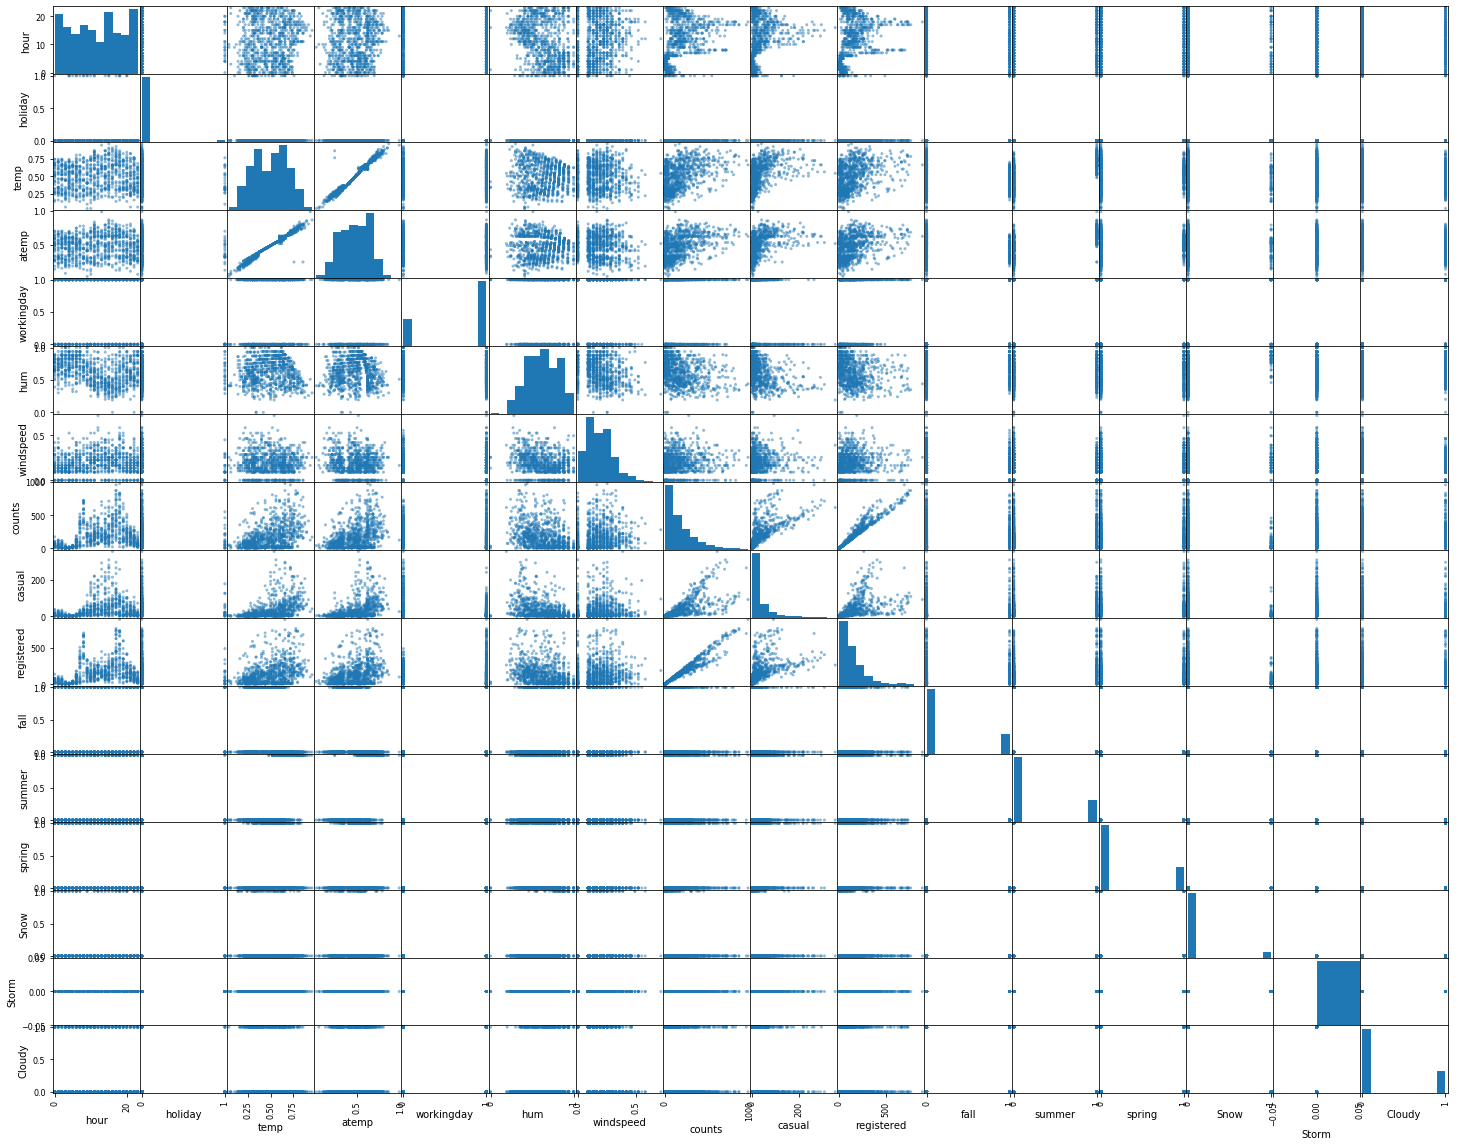

In [18]:
# your code here
cor_columns = ['hour', 'holiday', 'temp', 'atemp',
               'workingday', 'hum', 'windspeed',
               'counts', 'casual', 'registered',
               'fall', 'summer', 'spring',
               'Snow', 'Storm', 'Cloudy']
scatter_matrix(BSS_train[cor_columns].sample(frac=0.1, axis=0), 
               alpha=0.5, figsize=(25,20));

#### Temperature is strongly correlated with average temperature. Registered, casual are strongly correlated with count. This is expected since they are used to calculate the other.

**2.7 Make a plot showing the _average_ number of casual and registered riders...**

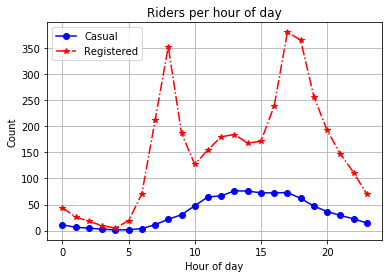

In [20]:
# your code here
hourgroup = BSS_train.groupby(["hour"], as_index=False)
avghour = hourgroup["casual", "registered"].aggregate('mean')

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(avghour["hour"], avghour["casual"], 'bo-', label="Casual")
ax.plot(avghour["hour"], avghour["registered"], 'r*-.', label="Registered")
ax.legend()
ax.grid()
ax.set_title("Riders per hour of day")
ax.set_xlabel("Hour of day")
ax.set_ylabel("Count");

#### The number of registered users peaks during morning (8am) and evening (5pm) rush hours. It is likely these registered users are going to/from work/school. Casual users peak around 11am to 6pm, but the numbers are far lesser. Probably they are tourists.

**2.8 Use the weather related variables to show how each weather...** 

In [21]:
# your code here
weather_mask = {"Cloudy": BSS_train["Cloudy"] == 1,
               "Storm": BSS_train["Storm"] == 1,
               "Snow": BSS_train["Snow"] == 1,
               "Clear": (BSS_train["Cloudy"] == 0) & (BSS_train["Storm"] == 0) & (BSS_train["Snow"] == 0)}

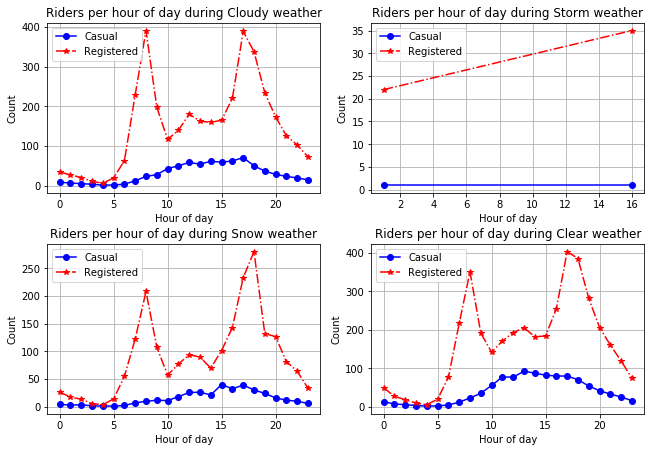

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9,6))
fig.subplots_adjust(wspace=0.7, hspace=0.5)
fig.tight_layout(pad=1, w_pad=2, h_pad=3)
i = 0

for weather, index in weather_mask.items():
    hourgroup = BSS_train[index].groupby(["hour"], as_index=False)
    avghour = hourgroup["casual", "registered"].aggregate('mean')
    axes[i//2][i%2].plot(avghour["hour"], avghour["casual"], 'bo-', label="Casual")
    axes[i//2][i%2].plot(avghour["hour"], avghour["registered"], 'r*-.', label="Registered")
    axes[i//2][i%2].legend()
    axes[i//2][i%2].grid()
    axes[i//2][i%2].set_title("Riders per hour of day during %s weather" %(weather))
    axes[i//2][i%2].set_xlabel("Hour of day")
    axes[i//2][i%2].set_ylabel("Count")
    i += 1

#### Snow, Cloudy and Clear weathers exhibit similar trends with 2 peaks for registered and a single flat peak for casual. However for Snow, the count is much lesser compared to Cloudy and Clear, probably because people hate the cold. For Storm, bikes seem to be rent only at 1am and 4pm, with the count less than 40.

---

<div class='exercise'> <b> Question 3 [18pts]: Multiple Linear Regression to Predict Hourly Ridership </b> </div>


**3.1** Use statsmodels to fit a multiple linear regression model to the training set using all the useable predictors (nothing that `count` was derived of and no interactions or polynomial terms) to predict `counts`, and report its $R^2$ score on the train and test sets.  Call this set of predictors `X_train`.

**3.2** Examine the estimated coefficients and report which ones are statistically significant at a significance level of 5% (p-value < 0.05). 

**3.3** You should see some strange estimates for the predictors representing months.  Carefully interpret the `July` coefficient, and explain why this result is likely occurring (be as specific as possible). 

**3.4** To diagnose the model, make two plots: first a histogram of the residuals, and second a plot of the residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Draw a horizontal line denoting the zero residual value on the Y-axis. What do the plots reveal about the OLS assumptions (linearity, constant variance, and normality)?

**3.5** Perhaps we can do better via a model with polynomial terms. Build a dataset `X_train_poly` from your `X_train` data from question 3.1 with added $x^2$ terms for `temp`, `hour`, and `humidity`. Are these polynomial terms important? How does predicted ridership change as each of `temp`, `hour`, and `humidity` increase?

**3.6** You should have received a warning regarding the presence of _multicolinearity_ in the model in 3.1.  Create a new dataset `X_train_drop` by dropping the following predictors from `X_train`:  `workingday` `atemp` `spring` `summer` and `fall` and fit a multiple linear regression model to the variables the remain.  Are the estimates more sensible in this model?  And explain in your own words why multicolinearity can lead to erroneous coefficient values.



### Answers

**3.1 Use statsmodels to fit a multiple linear regression model...**

In [23]:
BSS_train.columns

Index(['hour', 'holiday', 'year', 'workingday', 'temp', 'atemp', 'hum',
       'windspeed', 'casual', 'registered', 'counts', 'spring', 'summer',
       'fall', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct',
       'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy',
       'Snow', 'Storm'],
      dtype='object')

In [24]:
# your code here
predictors = ['hour', 'holiday', 'year', 'workingday', 'temp', 'atemp', 'hum',
       'windspeed', 'spring', 'summer', 'fall', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
       'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri',
       'Sat', 'Cloudy', 'Snow', 'Storm']
X_train = BSS_train[predictors]
y_train = BSS_train['counts']
model = OLS(y_train, sm.add_constant(X_train))
results = model.fit()

/home/dev15/anaconda3/envs/pandai/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [25]:
X_test = BSS_test[predictors]
y_test = BSS_test['counts']

y_test_pred = model.predict(results.params, exog=sm.add_constant(X_test))
y_train_pred = model.predict(results.params, exog=sm.add_constant(X_train))

r2_test = r2_score(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
print(f'Train R^2 Score: {r2_train} \t Test R^2 Score: {r2_test}')

Train R^2 Score: 0.4115699822629325 	 Test R^2 Score: 0.40072109229413466


**3.2 Examine the estimated coefficients and report...**

In [26]:
print(results.params[((results.pvalues < 0.05))])
results.summary()

const         -30.407500
hour            7.209247
holiday       -19.151036
year           78.121108
workingday     10.948441
temp          273.662515
atemp         162.535266
hum          -202.008009
spring         50.075412
summer         22.687920
fall           70.947417
Apr           -44.832594
May           -50.160547
Jun           -72.204151
Jul           -90.896453
Aug           -58.324552
Nov           -32.723179
Dec           -19.208751
Sat            12.746077
Snow          -26.815450
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     201.9
Date:                Tue, 04 Feb 2020   Prob (F-statistic):               0.00
Time:                        13:05:46   Log-Likelihood:                -55215.
No. Observations:                8689   AIC:                         1.105e+05
Df Residuals:                    8658   BIC:                         1.107e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -30.4075     10.908     -2.788      0.005     -51.789      -9.026
hour           7.2092      0.233     30.975      0.000       6.753       7.665
holiday      -19.1510      8.369     -2.288      0.022     -35.556      -2.746
year          78.1211      3.020     25.864      0.000      72.200      84.042
workingday    10.9484      3.512      3.118      0.002       4.065      17.832
temp         273.6625     61.680      4.437      0.000     152.755     394.570
atemp        162.5353     64.909      2.504      0.012      35.298     289.773
hum         -202.0080      9.927    -20.349      0.000    -221.468    -182.548
windspeed     19.3827     13.595      1.426      0.154      -7.268      46.033
spring        50.0754      9.528      5.256      0.000      31.398      68.753
summer        22.6879     11.138      2.037      0.042       0.855      44.521
fall          70.9474      9.448      7.509      0.000      52.426      89.469
Feb          -10.7198      7.590     -1.412      0.158     -25.598       4.158
Mar          -11.2938      8.385     -1.347      0.178     -27.731       5.143
Apr          -44.8326     12.635     -3.548      0.000     -69.600     -20.065
May          -50.1605     13.493     -3.718      0.000     -76.609     -23.712
Jun          -72.2042     13.700     -5.271      0.000     -99.058     -45.350
Jul          -90.8965     15.387     -5.907      0.000    -121.058     -60.735
Aug          -58.3246     15.061     -3.873      0.000     -87.847     -28.802
Sept         -16.1686     13.432     -1.204      0.229     -42.499      10.162
Oct          -15.8838     12.484     -1.272      0.203     -40.356       8.588
Nov          -32.7232     12.049     -2.716      0.007     -56.342      -9.104
Dec          -19.2088      9.560     -2.009      0.045     -37.949      -0.469
Mon           -3.3336      3.756     -0.888      0.375     -10.697       4.029
Tue           -0.0074      4.105     -0.002      0.999      -8.055       8.040
Wed           -2.2059      4.082     -0.540      0.589     -10.207       5.795
Thu           -5.5698      4.013     -1.388      0.165     -13.436       2.297
Fri            2.9140      4.015      0.726      0.468      -4.956      10.784
Sat           12.7461      5.587      2.281      0.023       1.793      23.699
Cloudy         6.9163      3.676      1.882      0.060      -0.289      14.122
Snow         -26.8155      6.094     -4.401      0.000     -38.760     -14.871
Storm         48.2045     98.839      0.488      0.626    -145.543     241.952
==============================================================================
Omnibus:                     1691.839   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3250.657
Skew:                           1.191   Prob(JB):                         0.00
Ku

**3.3 You should see some strange estimates for the predictors representing months...** 

#### Certain months have negative-valued parameters, meaning these months are likely to have low counts. In July, the magnitude is the largest, possibly because the weather is not only hot, but humid as well, making biking an unpleasant experience.

**3.4 To diagnose the model, make two plots:...**

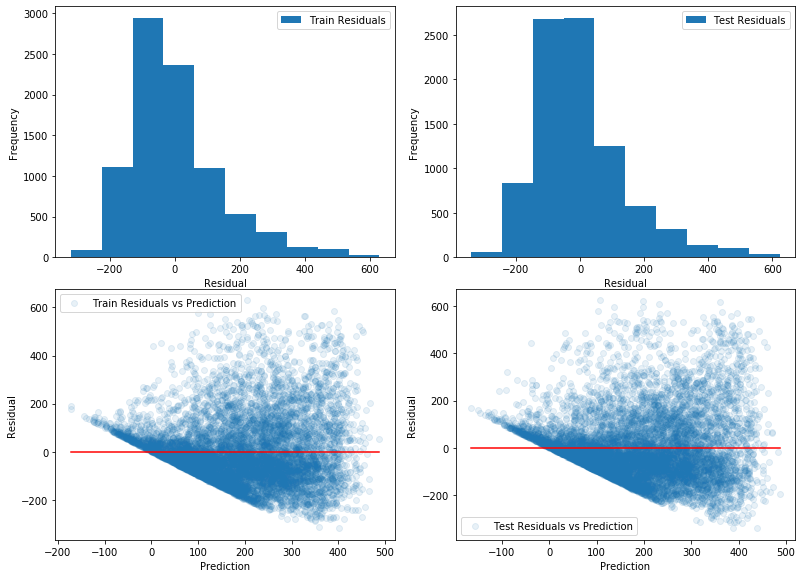

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11, 8))
fig.tight_layout(w_pad=3)

res_train = y_train - y_train_pred
res_test = y_test - y_test_pred

for i in range(2):
    whichset = ["Train", "Test"]
    whichpred = [y_train_pred, y_test_pred]
    whichres = [res_train, res_test]
    axes[0][i].hist(whichres[i], label="%s Residuals"%(whichset[i]))
    axes[0][i].legend()
    axes[0][i].set_xlabel("Residual")
    axes[0][i].set_ylabel("Frequency")

    axes[1][i].scatter(whichpred[i], whichres[i], label="%s Residuals vs Prediction"%(whichset[i]), alpha=0.1)
    axes[1][i].legend()
    axes[1][i].set_xlabel("Prediction")
    axes[1][i].set_ylabel("Residual")

    xrange = np.linspace(np.min(whichpred[i]), np.max(whichpred[i]), 100)
    axes[1][i].plot(xrange, [0]*100, 'r-')

#### The histogram does not exhibit __normality__ as the residuals are skewed
#### The plot does not exhibit __heteroscedasticity/constant variance__ as the residuals fan-out in a triangular fashion, instead of rectangular
#### The plot does not exhibit __linearity__ as the scatter is not linear especially when predictions have large values.

**3.5 Perhaps we can do better via a model...**

In [29]:
X_train_poly = X_train.copy()
X_train_poly['hour2'] = X_train_poly.hour**2
X_train_poly['temp2'] = X_train_poly.temp**2
X_train_poly['hum2'] = X_train_poly.hum**2

X_test_poly = X_test.copy()
X_test_poly['hour2'] = X_test_poly.hour**2
X_test_poly['temp2'] = X_test_poly.temp**2
X_test_poly['hum2'] = X_test_poly.hum**2

poly_model = OLS(y_train, sm.add_constant(X_train_poly)).fit()
print(r2_score(y_test, poly_model.predict(sm.add_constant(X_test_poly))))
print(poly_model.params[['hour2', 'temp2', 'hum2']])
print(poly_model.params[['hour', 'temp', 'hum']])
poly_model.summary()

0.49059037908107217
hour2     -1.388106
temp2    140.680411
hum2    -126.887299
dtype: float64
hour    40.221100
temp    46.009614
hum     42.317070
dtype: float64


/home/dev15/anaconda3/envs/pandai/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     271.3
Date:                Tue, 04 Feb 2020   Prob (F-statistic):               0.00
Time:                        13:05:58   Log-Likelihood:                -54433.
No. Observations:                8689   AIC:                         1.089e+05
Df Residuals:                    8655   BIC:                         1.092e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -193.3332     17.588    -10.992      0.000    -227.810    -158.857
hour          40.2211      0.840     47.896      0.000      38.575      41.867
holiday      -14.0310      7.656     -1.833      0.067     -29.039       0.977
year          83.2098      2.781     29.921      0.000      77.758      88.661
workingday    13.2241      3.212      4.117      0.000       6.928      19.520
temp          46.0096     78.769      0.584      0.559    -108.397     200.416
atemp        148.5309     61.182      2.428      0.015      28.599     268.463
hum           42.3171     45.426      0.932      0.352     -46.729     131.363
windspeed    -19.4101     12.531     -1.549      0.121     -43.973       5.153
spring        46.8322      8.714      5.374      0.000      29.750      63.914
summer        25.4085     10.202      2.490      0.013       5.410      45.407
fall          74.7289      8.643      8.646      0.000      57.787      91.671
Feb           -2.2754      7.037     -0.323      0.746     -16.070      11.519
Mar            9.1429      7.906      1.156      0.248      -6.355      24.641
Apr          -12.2792     11.781     -1.042      0.297     -35.373      10.814
May          -15.6791     12.489     -1.255      0.209     -40.160       8.802
Jun          -29.8762     12.639     -2.364      0.018     -54.652      -5.100
Jul          -51.5208     14.156     -3.640      0.000     -79.269     -23.773
Aug          -23.3642     13.901     -1.681      0.093     -50.613       3.884
Sept          11.0442     12.519      0.882      0.378     -13.495      35.584
Oct           -1.9320     11.682     -0.165      0.869     -24.831      20.967
Nov          -27.7996     11.221     -2.478      0.013     -49.795      -5.804
Dec          -19.1169      8.871     -2.155      0.031     -36.506      -1.728
Mon           -0.9673      3.434     -0.282      0.778      -7.699       5.764
Tue            0.9441      3.753      0.252      0.801      -6.412       8.301
Wed           -1.8581      3.731     -0.498      0.619      -9.172       5.456
Thu           -2.7283      3.669     -0.744      0.457      -9.921       4.465
Fri            3.8028      3.671      1.036      0.300      -3.393      10.999
Sat           18.1315      5.113      3.546      0.000       8.109      28.154
Cloudy        -9.5074      3.389     -2.805      0.005     -16.151      -2.864
Snow         -46.9213      5.765     -8.139      0.000     -58.222     -35.620
Storm         34.1383     90.378      0.378      0.706    -143.024     211.301
hour2         -1.3881      0.034    -40.654      0.000      -1.455      -1.321
temp2        140.6804     46.276      3.040      0.002      49.968     231.393
hum2        -126.8873     36.621     -3.465      0.001    -198.673     -55.102
==============================================================================
Om

#### Only hour squared is insignifcant compared to temperature squared and humidity squared, as denoted by their magnitudes.
#### Predicted ridership decreases as temperature and humidity increases, but increases with hour.

**3.6 You should have received a warning regarding the presence of _multicollinearity_...**

In [30]:
drops = ["workingday", "atemp", "spring", "summer", "fall"]

X_train_drop = X_train.drop(drops, axis=1)
X_test_drop = X_test.drop(drops, axis=1)
print(X_train_drop.columns)

drop_model = OLS(y_train, sm.add_constant(X_train_drop)).fit()
print(r2_score(y_test, drop_model.predict(sm.add_constant(X_test_drop))))
drop_model.summary()

Index(['hour', 'holiday', 'year', 'temp', 'hum', 'windspeed', 'Feb', 'Mar',
       'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon',
       'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm'],
      dtype='object')
0.39719478258457475


/home/dev15/anaconda3/envs/pandai/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     226.9
Date:                Tue, 04 Feb 2020   Prob (F-statistic):               0.00
Time:                        13:06:03   Log-Likelihood:                -55263.
No. Observations:                8689   AIC:                         1.106e+05
Df Residuals:                    8662   BIC:                         1.108e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -26.2056     10.772     -2.433      0.015     -47.322      -5.089
hour           7.2218      0.234     30.871      0.000       6.763       7.680
holiday      -37.2529      9.390     -3.967      0.000     -55.659     -18.846
year          77.9687      3.035     25.691      0.000      72.020      83.918
temp         425.3856     16.922     25.137      0.000     392.214     458.557
hum         -198.2002      9.944    -19.933      0.000    -217.692    -178.709
windspeed      3.0647     13.166      0.233      0.816     -22.743      28.872
Feb          -10.3801      7.624     -1.362      0.173     -25.324       4.564
Mar            4.8473      7.834      0.619      0.536     -10.510      20.205
Apr            5.6103      8.422      0.666      0.505     -10.899      22.119
May           -2.4330      9.725     -0.250      0.802     -21.497      16.631
Jun          -35.3982     10.671     -3.317      0.001     -56.316     -14.480
Jul          -72.2768     11.583     -6.240      0.000     -94.982     -49.571
Aug          -40.9043     11.043     -3.704      0.000     -62.551     -19.258
Sept          15.9133     10.059      1.582      0.114      -3.805      35.632
Oct           54.0377      8.686      6.221      0.000      37.010      71.065
Nov           38.3870      7.796      4.924      0.000      23.106      53.668
Dec           26.2086      7.582      3.457      0.001      11.346      41.071
Mon            9.6638      5.802      1.666      0.096      -1.709      21.036
Tue           11.4788      5.705      2.012      0.044       0.295      22.663
Wed            8.5964      5.676      1.515      0.130      -2.529      19.722
Thu            5.9261      5.641      1.050      0.294      -5.132      16.984
Fri           13.5104      5.640      2.396      0.017       2.455      24.566
Sat           12.3255      5.614      2.196      0.028       1.321      23.330
Cloudy         7.0689      3.692      1.915      0.056      -0.169      14.306
Snow         -27.3958      6.112     -4.483      0.000     -39.376     -15.415
Storm         44.8939     99.348      0.452      0.651    -149.852     239.640
==============================================================================
Omnibus:                     1712.709   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3312.120
Skew:                           1.202   Prob(JB):                         0.00
Kurtosis:                       4.837   Cond. No.                         898.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### The coefficients are more sensible now. Before, temp and atemp had small coefficients (162, 273 vs 425) but large variance/interval (61, 64 vs 16). This is expected since temp should have a strong, positive relationship with count (ie. a large positive coefficient) and the model is sure of this relationship since the spread is only 16.
#### For months Feb to Dec, the coefficients now exhibit a sinusoidal pattern compared to earlier where all were negative. This should be the case as certain months are warm and sunny which promotes bike-riding, whereas months that are cold have fewer riders.

---

<div class='exercise'> <b> Question 4 [20pts]: Regression Models with Polynomial and Interaction Terms </b> </div>

**4.1** Drop the variables `workingday`, `atemp`, `spring`, `summer`, `fall`, and  `dteday` from `BSS_train` (if any of them still remain).

**4.2** Write a function to standardize a provided subset of columns in your training/validation/test sets. Remember that while you will be scaling all of your data, you must learn the scaling parameters (mean and SD) from only the training set.

Test your code by building a list of all non-binary columns from `X_train` into a dataset called `practice_X_train` and scaling only those columns. Call the result `practice_X_train_scaled`. Display the `.describe()` and verify that you have correctly scaled all columns, including the polynomial columns.

**Hint: employ the provided list of binary columns and use `pd.columns.difference()`**

`binary_columns = [ 'holiday', 'workingday','Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
       'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm']`


**4.3** Write a code to augment your a dataset with higher-order features for `temp`, `hum`,`windspeed`, and `hour`. You should include ONLY the pure powers of these columns. So with degree=2 you should produce `temp^2` and `hum^2` but not `temp*hum` or any other two-feature interactions. 

Encapsulate this process as a function with appropriate inputs and outputs, and test your code by producing `practice_X_train_poly`, a training dataset with quadratic and cubic features built from `practice_X_train_scaled`, and printing `practice_X_train_poly`'s column names and `.head()`.

**4.4** Write code to add interaction terms to the model. Specifically, we want interactions between the continuous predictors (`temp`, `hum`,`windspeed`) and the month and weekday dummies (`Feb`, `Mar`...`Dec`, `Mon`, `Tue`, ... `Sat`). That means you SHOULD build `temp*Feb` and `hum*Mon` and so on, but NOT `Feb*Mar` and NOT `Feb*Tue`. The interaction terms should always be a continuous feature times a month dummy or a continuous feature times a weekday dummy.

Encapsulate this process as a function with appropriate inputs and outputs, and test your code by adding interaction terms to `practice_X_train_poly` and show its column names and `.head()`**

**4.5** Combine all your code so far into a function named `get_design_mats` that takes in `BSS_train`, `BSS_test`, the names of columns for polynomial, the target column, the columns to be dropped and produces computation-ready design matrices `X_train` and `X_test` and responses `y_train` and `y_test`. Your final function should build correct, scaled design matrices with the stated interaction terms and any polynomial degree.


**4.6** For each degree in 1 through 8:

1.  Build the training design matrix and validation design matrix using the function `get_design_mats` with polynomial terms up through the specified degree.

2.  Fit a regression model to the training data.

3.  Report the model's score on the test data.

**4.7** Discuss patterns you see in the results from 4.5. Which model would you select, and why?

### Answers

**4.1 Drop...**

In [6]:
drops = ["workingday", "atemp", "casual", "registered"]  # drop collinear variables
train_dropped = BSS_train.drop(drops, axis=1)
y_train = train_dropped["counts"]
train_dropped.drop(["counts"], axis=1, inplace=True)
X_train = train_dropped

**4.2 Write a function to standardize...**

In [7]:
def standardize(dataframe, columns, stats=None):
    """
    Standardizes a Dataframe.
    First removes columns.
    Also returns mean and std if the frame is for training.
    """
    continuous = dataframe[dataframe.columns.difference(columns)]
    if stats is None:
        mean = continuous.mean()
        std = continuous.std()
    else:
        mean, std = stats
    normalized_df = (continuous - mean) / continuous.std()
    dataframe[dataframe.columns.difference(columns)] = normalized_df
    
    if stats is None:
        return dataframe, mean, std
    else:
        return dataframe

In [8]:
binary_columns = ['holiday', "spring", "summer", "fall", 'Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec',
        'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm']

In [9]:
practice_X_train_scaled, _ ,_ = standardize(X_train, binary_columns, None)
practice_X_train_scaled.describe()

,hour,holiday,year,temp,hum,windspeed,spring,summer,fall,Feb,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
count,8.689000e+03,8689.000000,8.689000e+03,8.689000e+03,8.689000e+03,8.689000e+03,8689.000000,8689.000000,8689.000000,8689.000000,...,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000
mean,5.335817e-17,0.029347,-2.862124e-17,1.178112e-14,3.877606e-14,7.456896e-14,0.250316,0.259293,0.243641,0.077224,...,0.085280,0.144205,0.137875,0.141788,0.144551,0.143975,0.146047,0.257567,0.083324,0.000230
std,1.000000e+00,0.168788,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.433220,0.438272,0.429303,0.266962,...,0.279314,0.351318,0.344789,0.348853,0.351667,0.351085,0.353173,0.437319,0.276387,0.015171
min,-1.666263e+00,0.000000,-1.006755e+00,-2.474050e+00,-3.251787e+00,-1.546547e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-8.042200e-01,0.000000,-1.006755e+00,-8.122357e-01,-7.554373e-01,-6.986934e-01,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.782341e-02,0.000000,9.931755e-01,1.867126e-02,-2.733539e-02,2.745877e-02,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.198668e-01,0.000000,9.931755e-01,8.495782e-01,8.047811e-01,5.118307e-01,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.638236e+00,1.000000,9.931755e-01,2.511392e+00,1.948941e+00,5.355550e+00,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**4.3 Write code to augment your a dataset with higher-order features for...**

In [10]:
def raise_power(df, columns=None, expo=2):
    if columns is None:
        columns = df.columns
    for e in range(2, expo+1):  # expo=3 means x^3 x^2 ... NOT x^3 only
        for col in columns:
            df[col+"_"+str(e)] = df[col]**e
    return df

In [11]:
power_columns = ["temp", "hum", "windspeed", "hour"]
practice_X_train_poly = raise_power(X_train, power_columns)
practice_X_train_poly.columns

Index(['hour', 'holiday', 'year', 'temp', 'hum', 'windspeed', 'spring',
       'summer', 'fall', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
       'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm', 'temp_2', 'hum_2', 'windspeed_2', 'hour_2'],
      dtype='object')

**4.4 Write code to add interaction terms to the model...**

In [12]:
def interact(df, continuous, discrete):
    for cont in continuous:
        for dis in discrete:
            df[cont+"*"+dis] = df[cont]*df[dis]
    return df

continuous_columns = ['temp','hum','windspeed']

In [13]:
interactive = interact(practice_X_train_poly, continuous_columns, binary_columns[1:-3]) # only certain binaries
interactive.columns

Index(['hour', 'holiday', 'year', 'temp', 'hum', 'windspeed', 'spring',
       'summer', 'fall', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
       'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm', 'temp_2', 'hum_2', 'windspeed_2', 'hour_2',
       'temp*spring', 'temp*summer', 'temp*fall', 'temp*Feb', 'temp*Mar',
       'temp*Apr', 'temp*May', 'temp*Jun', 'temp*Jul', 'temp*Aug', 'temp*Sept',
       'temp*Oct', 'temp*Nov', 'temp*Dec', 'temp*Mon', 'temp*Tue', 'temp*Wed',
       'temp*Thu', 'temp*Fri', 'temp*Sat', 'hum*spring', 'hum*summer',
       'hum*fall', 'hum*Feb', 'hum*Mar', 'hum*Apr', 'hum*May', 'hum*Jun',
       'hum*Jul', 'hum*Aug', 'hum*Sept', 'hum*Oct', 'hum*Nov', 'hum*Dec',
       'hum*Mon', 'hum*Tue', 'hum*Wed', 'hum*Thu', 'hum*Fri', 'hum*Sat',
       'windspeed*spring', 'windspeed*summer', 'windspeed*fall',
       'windspeed*Feb', 'windspeed*Mar', 'windspeed*Apr', 'windspeed*May',
       'windspeed*Jun', 'windspee

**4.5 Combine all your code so far into a function named...**

In [14]:
def get_design_mats(train_df, val_df, degree, 
                    columns_forpoly=['temp', 'hum', 'windspeed', 'hour'],
                    target_col='counts',
                    bad_columns=None):
    """
    :param train_df: The training data
    :param val_df: Your test/validation data
    :param columns_forpoly: List containing the column name for which we want to create 
                            polynomial terms
    :param target_col: The response variable column
    :param bad_columns: The columns you want to drop
    """
    Xs = []
    ys = []
    
    for i, df in enumerate([train_df, val_df]):
        y = df[target_col]
        X = df.drop([target_col], axis=1)
        X.drop(bad_columns, axis=1, inplace=True)
        if i == 0:
            X, mean, std = standardize(X, binary_columns, None)
        else:
            X = standardize(X, binary_columns, (mean, std))
        
        if degree > 1: # Power 2 and above
            X = raise_power(X, columns_forpoly, degree)
        X = interact(X, continuous_columns, binary_columns[1:-3]) # only certain binaries
        Xs.append(X)
        ys.append(y)
    
    x_train, x_val = Xs
    y_train, y_val = ys

    return x_train, y_train, x_val, y_val

In [15]:
x_train, y_train, x_test, y_test = get_design_mats(BSS_train, BSS_test, 2, bad_columns=drops)

In [16]:
x_train.describe()

,hour,holiday,year,temp,hum,windspeed,spring,summer,fall,Feb,...,windspeed*Sept,windspeed*Oct,windspeed*Nov,windspeed*Dec,windspeed*Mon,windspeed*Tue,windspeed*Wed,windspeed*Thu,windspeed*Fri,windspeed*Sat
count,8.689000e+03,8689.000000,8.689000e+03,8.689000e+03,8.689000e+03,8.689000e+03,8689.000000,8689.000000,8689.000000,8689.000000,...,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000
mean,5.335817e-17,0.029347,-2.862124e-17,1.178112e-14,3.877606e-14,7.456896e-14,0.250316,0.259293,0.243641,0.077224,...,-0.018334,-0.013420,-0.004616,-0.007543,-0.001365,0.004269,-0.003621,0.001751,-0.002836,0.005889
std,1.000000e+00,0.168788,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.433220,0.438272,0.429303,0.266962,...,0.266038,0.301259,0.287817,0.302338,0.386071,0.371281,0.380900,0.363119,0.391164,0.384242
min,-1.666263e+00,0.000000,-1.006755e+00,-2.474050e+00,-3.251787e+00,-1.546547e+00,0.000000,0.000000,0.000000,0.000000,...,-1.546547,-1.546547,-1.546547,-1.546547,-1.546547,-1.546547,-1.546547,-1.546547,-1.546547,-1.546547
25%,-8.042200e-01,0.000000,-1.006755e+00,-8.122357e-01,-7.554373e-01,-6.986934e-01,0.000000,0.000000,0.000000,0.000000,...,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.782341e-02,0.000000,9.931755e-01,1.867126e-02,-2.733539e-02,2.745877e-02,0.000000,0.000000,0.000000,0.000000,...,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000
75%,9.198668e-01,0.000000,9.931755e-01,8.495782e-01,8.047811e-01,5.118307e-01,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.638236e+00,1.000000,9.931755e-01,2.511392e+00,1.948941e+00,5.355550e+00,1.000000,1.000000,1.000000,1.000000,...,3.660654,3.176282,3.418062,3.781544,4.265916,4.750288,3.660654,3.660654,4.992879,5.234659


In [17]:
x_train.columns

Index(['hour', 'holiday', 'year', 'temp', 'hum', 'windspeed', 'spring',
       'summer', 'fall', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
       'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm', 'temp_2', 'hum_2', 'windspeed_2', 'hour_2',
       'temp*spring', 'temp*summer', 'temp*fall', 'temp*Feb', 'temp*Mar',
       'temp*Apr', 'temp*May', 'temp*Jun', 'temp*Jul', 'temp*Aug', 'temp*Sept',
       'temp*Oct', 'temp*Nov', 'temp*Dec', 'temp*Mon', 'temp*Tue', 'temp*Wed',
       'temp*Thu', 'temp*Fri', 'temp*Sat', 'hum*spring', 'hum*summer',
       'hum*fall', 'hum*Feb', 'hum*Mar', 'hum*Apr', 'hum*May', 'hum*Jun',
       'hum*Jul', 'hum*Aug', 'hum*Sept', 'hum*Oct', 'hum*Nov', 'hum*Dec',
       'hum*Mon', 'hum*Tue', 'hum*Wed', 'hum*Thu', 'hum*Fri', 'hum*Sat',
       'windspeed*spring', 'windspeed*summer', 'windspeed*fall',
       'windspeed*Feb', 'windspeed*Mar', 'windspeed*Apr', 'windspeed*May',
       'windspeed*Jun', 'windspee

**4.6 For each degree in 1 through 8...**

For each degree in 1 through 8:

Build the training design matrix and validation design matrix using the function get_design_mats with polynomial terms up through the specified degree.

Fit a regression model to the training data.

Report the model's score on the test data.

In [18]:
test_scores = []
train_scores = []
for deg in range(1,9):
    x_train, y_train, x_test, y_test = get_design_mats(BSS_train, BSS_test, deg, bad_columns=drops)
    model = OLS(y_train, sm.add_constant(x_train)).fit()
    train_scores.append(r2_score(y_train, model.predict(sm.add_constant(x_train))))
    test_scores.append(r2_score(y_test, model.predict(sm.add_constant(x_test))))
pd.DataFrame({'train_score': train_scores, 'test_score': test_scores})

/home/dev15/anaconda3/envs/pandai/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/dev15/anaconda3/envs/pandai/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/dev15/anaconda3/envs/pandai/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/dev15/anaconda3/envs/pandai/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/dev15/anaconda3/envs/panda

,train_score,test_score
0,0.443663,0.432868
1,0.532063,0.515249
2,0.575779,0.563416
3,0.577740,0.566527
4,0.592306,0.577463
5,0.614812,0.599562
6,0.653423,0.634883
7,0.662732,0.645272


**4.7 Discuss patterns you see in the results...**

#### The model with degree 8 is best as it has the highest test score. Even at degree 8, the difference in train and test score is not significant, indicating that the model still has not overfit even with degree of 8.

---

<div class='exercise'> <b> Question 5 [20pts]: Regularized Models </b> </div>

**5.1** Let's try regularizing our models via ridge regression. Split the training set, `BSS_train`, into an 80-20 train-validation split.  Build a table showing the validation set $R^2$ of polynomial models with degree from 1-8, regularized at the levels $\lambda = (.01, .05, .1,.5, 1, 5, 10, 50, 100)$. Do not perform cross validation at this point, simply report performance on the single validation set. 

**5.2** Find the best-scoring degree and regularization combination.

**5.3** It's time to see how well our selected model will do on future data. Use the earlier created test dataset, do any required formatting, and report the best model's $R^2$ score. How does it compare to the validation set score that made us choose this model? Does the test set simply have observations that are more difficult or easier to predict?

**5.4** Build a dataset with polynomial degree 1 and fit an OLS model, a Ridge model, and a Lasso model. Use `RidgeCV` and `LassoCV` to select the best regularization level from among `(.1,.5,1,5,10,50,100)`. 

Note: On the lasso model, you may need to increase `max_iter` (start with 100,000) for the optimization to converge.

**5.5** Plot histograms of the coefficients found by each of OLS, ridge, and lasso. What trends do you see in the magnitude of the coefficients?

**5.6** The plots above show the overall distribution of coefficient values in each model, but do not show how each model treats individual coefficients. Build a plot which cleanly presents, for each feature in the data, 1) The coefficient assigned by OLS, 2) the coefficient assigned by ridge, and 3) the coefficient assigned by lasso.

**Hint: Bar plots are a possible choice, but you are not required to use them**

**Hint: use `xticks` to label coefficients with their feature names**

**5.7** What trends do you see in the plot above?

### Answers

**5.1 Let's try regularizing our models via...** 

In [27]:
bike_train, bike_val = train_test_split(BSS_train, test_size=0.2)
ls = [.01, .05, .1, .5, 1, 5, 10, 50, 100]
val_score = []
train_score = []

for deg in range(1,9):
    x_train, y_train, x_val, y_val = get_design_mats(bike_train, bike_val, deg, bad_columns=drops)
    for l in ls:
        model = Ridge(alpha=l).fit(x_train, y_train)
        train_score.append(model.score(x_train, y_train))
        val_score.append(model.score(x_val, y_val))

**5.2 Find the best-scoring degree and regularization combination.**

In [28]:
degrees = list()
for deg in range(1,9):
    degrees.extend([deg]*len(ls))

strengths = list()
for deg in range(1,9):
    strengths.extend(ls)

results = pd.DataFrame({"Regularization Strength": strengths, "Degrees": degrees,
              'train_score': train_score, 'val_score': val_score})
# results.head()
results.iloc[results["val_score"].argmax()]

/home/dev15/anaconda3/envs/pandai/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  if sys.path[0] == '':


Regularization Strength    0.010000
Degrees                    8.000000
train_score                0.663362
val_score                  0.654946
Name: 63, dtype: float64

**5.3 It's time to see how well our selected model...**


In [29]:
x_train, y_train, x_test, y_test = get_design_mats(bike_train, BSS_test, 8, bad_columns=drops)
best_model = Ridge(alpha=0.01).fit(x_train, y_train)
best_model.score(x_test, y_test)

0.6442062727945037

#### Test performance was slightly lower than validation

**5.4 Build a dataset with polynomial degree 1...**

In [42]:
X_train, y_train, X_test, y_test = get_design_mats(BSS_train, BSS_test, 1, bad_columns=drops)

fitted_OLS = LinearRegression().fit(X_train, y_train)

alphas = (.1,.5,1,5,10,50,100)

fitted_ridge = RidgeCV(alphas=alphas).fit(X_train, y_train)
fitted_lasso = LassoCV(alphas=alphas, max_iter=100000).fit(X_train, np.ravel(y_train))

/home/dev15/anaconda3/envs/pandai/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


**5.5 Plot histograms of the coefficients found...**

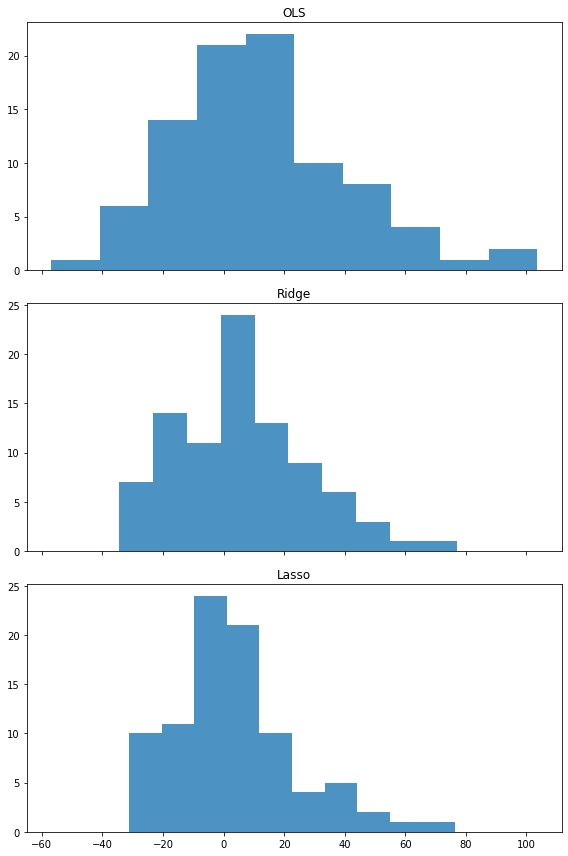

In [44]:
# your code here
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8, 12))

axs[0].hist(model.coef_, alpha=0.8)
axs[0].set_title("OLS")

axs[1].hist(Ridge_model.coef_, alpha=0.8)
axs[1].set_title("Ridge")

axs[2].hist(Lasso_model.coef_, alpha=0.8)
axs[2].set_title("Lasso")
plt.tight_layout()

#### The coefficients have shrunk using LASSO or Ridge, since the frequency of bins close to magnitude 0 are much higher, and the distribution is more compact. Compared to the bins for OLS, where they are more evenly spread-out, it means less coefficients have magnitude close to 0.

**5.6 The plots above show the overall distribution of...**

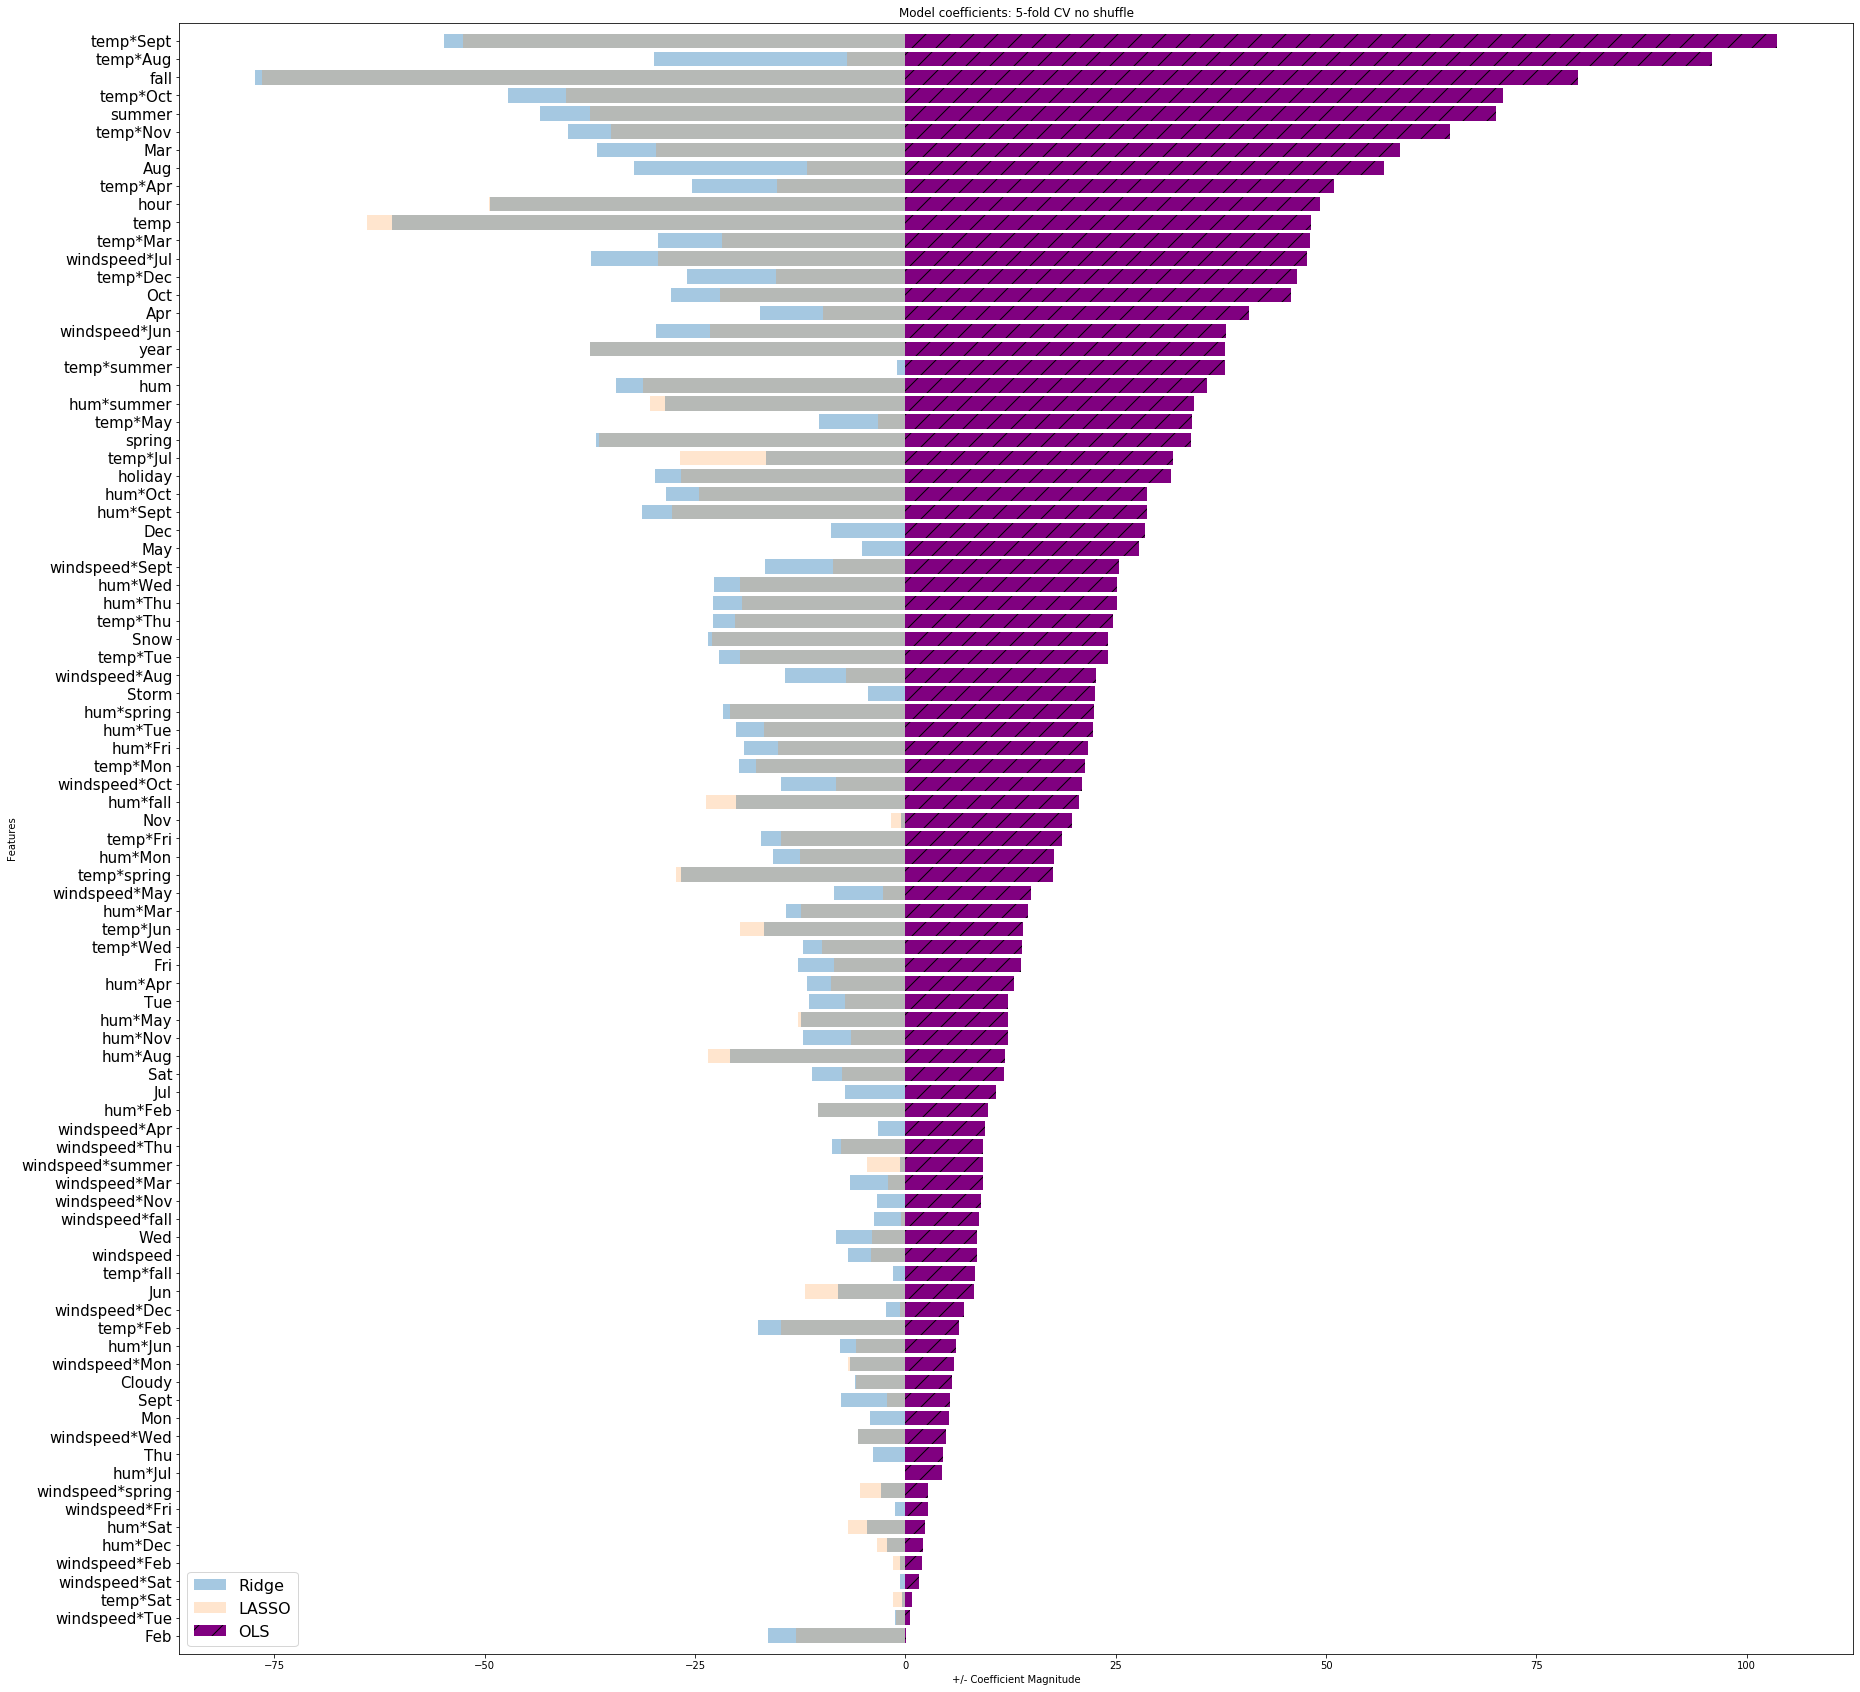

In [49]:
feature_names = X_train.columns.values

Ridge_coefficients = Ridge_model.coef_
Lasso_coefficients = Lasso_model.coef_
OLS_coefficients = model.coef_

si= np.argsort(np.abs(model.coef_))
feature_names = X_train.columns.values[si]
n_coeffs = len(feature_names)

plt.figure(figsize=(30,30))
plt.barh(np.arange(n_coeffs), 
         -np.abs(Ridge_coefficients)[si], 
         alpha=0.4, label='Ridge')
plt.barh(np.arange(n_coeffs), 
         -np.abs(Lasso_coefficients)[si], 
         alpha=0.2, label='LASSO')
plt.barh(np.arange(n_coeffs), 
         np.abs(OLS_coefficients)[si], 
         color='purple', hatch='/', label='OLS')

plt.yticks(range(n_coeffs), feature_names, rotation=0, fontsize=15)
plt.ylim(-1,n_coeffs)
#plt.xlim(-100,300)

plt.legend(fontsize=16)

plt.title("Model coefficients: 5-fold CV no shuffle")
plt.ylabel("Features")
plt.xlabel("+/- Coefficient Magnitude");

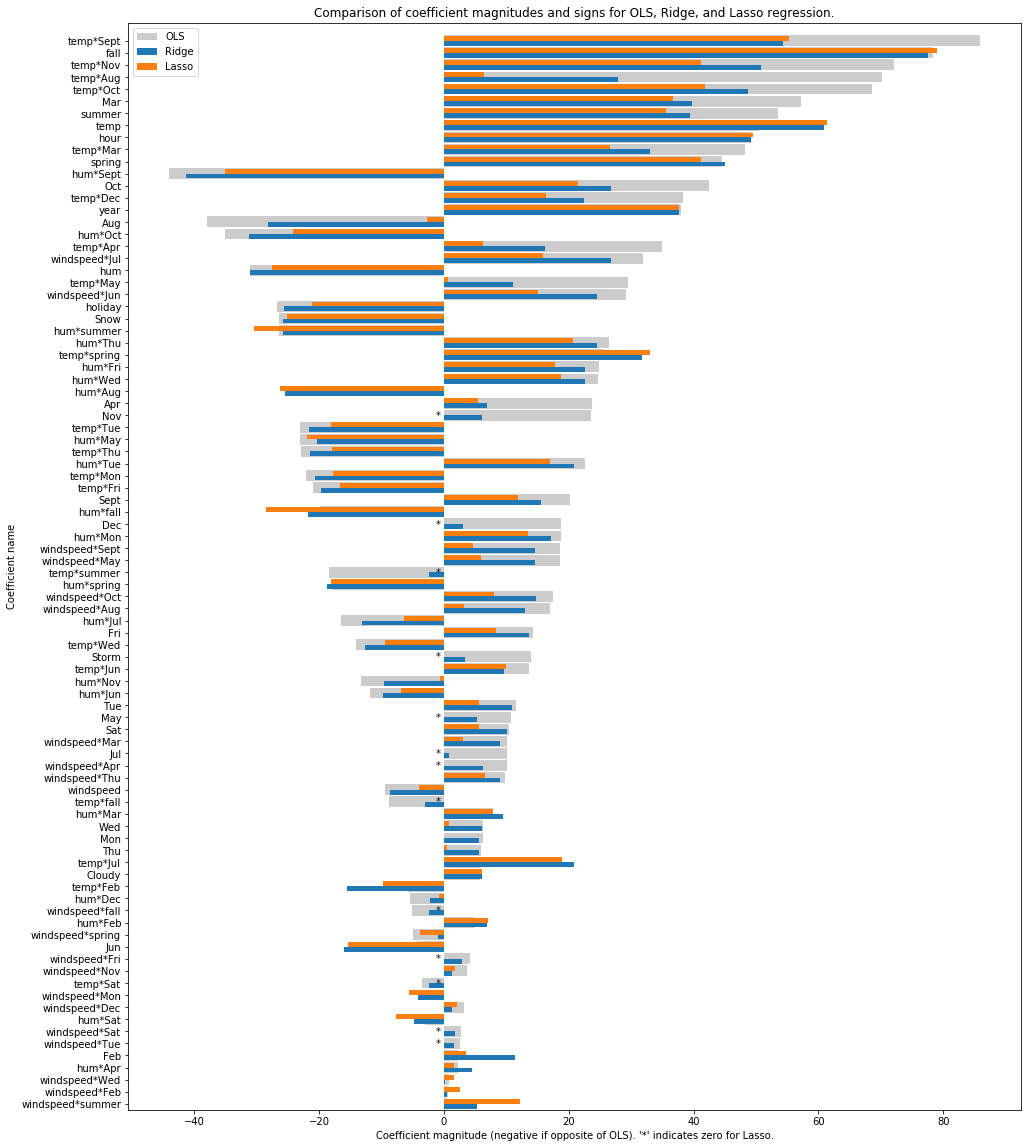

In [50]:
feature_names = X_train.columns.values
n_coeffs = len(feature_names)

coef_labels = X_train.columns
coef_ticks = np.arange(len(coef_labels))
label_order = np.argsort(np.abs(fitted_OLS.coef_))

fig, ax = plt.subplots(1, 1, figsize=(16, 20))
signs = np.sign(fitted_OLS.coef_[label_order])

ax.barh(coef_ticks, (signs * np.abs(fitted_OLS.coef_)[label_order]) , height=.9, color='#cccccc', label='OLS')
ax.barh(coef_ticks-.2, (signs * np.abs(fitted_ridge.coef_)[label_order]), alpha=1, height=.4, label='Ridge')
ax.barh(coef_ticks+.2, (signs * np.abs(fitted_lasso.coef_)[label_order]), alpha=1, height=.4, label="Lasso")

plt.yticks(coef_ticks, coef_labels[label_order], rotation=0, fontsize=10) ; 
plt.ylim([-.5, len(coef_labels) + .5])

# Mark Lasso zeros
for y, idx in enumerate(label_order):
    if np.abs(fitted_lasso.coef_[idx]) < 1e-3:
        plt.text(-.5, y, '*', verticalalignment='center', horizontalalignment='right')
plt.legend(loc='best');
plt.xlabel("Coefficient magnitude (negative if opposite of OLS). '*' indicates zero for Lasso.")
plt.ylabel("Coefficient name")
plt.title("Comparison of coefficient magnitudes and signs for OLS, Ridge, and Lasso regression.");

**5.7 What trends do you see...**

In the plots above, we can see that on average the Ridge and Lasso models shrank the coefficients when compared to those estimated by OLS (see figure 2). In general, the coefficient shrinkage exhibited by Lasso is greater than that exhibited by Ridge, with many coefficients (Storm, Dec, etc.) shrunk to zero (at least when reported by two decimal points), effectively removing any effects by those predictors from the model. The Ridge and Lasso coefficients for the predictor Storm are particularly striking because of the degree to which those estimated coefficients shrunk by 30+ rides for Ridge and by 40+ rides for Lasso. This however makes perfect sense if we refer back to the estimated coefficient and 95% CI plots generated in parts 3.2, 3.5, and 3.6, where the Storm 95% CI was very wide and included zero within its bounds. Considering that there are only $n=2$ Storm observations in our training dataset, this predictor has very little opportunity to influence the model.

---

<div class='exercise'> <b> Question 6 [16 pts]: Reflection </b></div>
These problems are open-ended, and you are not expected to write more than 2-3 sentences. We are interested in seeing that you have thought about these issues; you will be graded on how well you justify your conclusions here, not on what you conclude.

**6.1** Reflect back on the `get_design_mats` function you built. In what way was writing this function useful in your analysis? What issues might you have encountered if you copy/pasted the model-building code instead of tying it together in a function? Does a `get_design_mat` function seem wise in general, or are there better options?

**6.2** What are the costs and benefits of applying ridge/lasso regularization to an overfit OLS model, versus setting a specific degree of polynomial or forward selecting polynomial features for the model?

**6.3** This pset posed a purely predictive goal: forecast ridership as accurately as possible. How important is interpretability in this context? Considering, e.g., your lasso and ridge models from Question 5, how would you react if the models predicted well, but the coefficient values didn't make sense once interpreted?

**6.4** Reflect back on our original goal of helping BikeShare predict what demand will be like in the week ahead, and thus how many bikes they can bring in for maintenance. In your view, did we accomplish this goal? If yes, which model would you put into production and why? If not, which model came closest, what other analyses might you conduct, and how likely do you think they are to work?


### Answers

**6.1 Reflect back on the get_design_mats function you built...**

*your answer here*

**6.2 What are the costs and benefits of applying ridge/lasso...**

*your answer here*

**6.3 This pset posed a purely predictive goal: forecast ridership...**

*your answer here*

**6.4 Reflect back on our original goal of helping BikeShare predict...**

*your answer here*